In [67]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
#import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture
import pickle
from netCDF4 import num2date, date2num
import math

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import metpy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.img_tiles as cimgt
import glob
import pandas as pd
from cartopy.io.img_tiles import MapboxTiles
#from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import scipy.ndimage as spyi
from string import ascii_lowercase as alphabet

In [73]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
def give_gatefilter(myradar,despecke=50,mindop=0.5,maxdop=-10,snr=2,minref=20):
    
    gatefilter = pyart.correct.GateFilter(myradar)

    if snr is not None:
        try:
            myradar.check_field_exists('SNR')
        except:
            myradar.add_field('SNR',
                              pyart.retrieve.calculate_snr_from_reflectivity(myradar,
                                                                             refl_field='DBZH', 
                                                                             snr_field=None, 
                                                                             toa=25000.0))
            gatefilter.exclude_below('SNR',snr)
    if mindop is not None:
        gatefilter.exclude_inside('VRADH',-mindop,mindop)
    if maxdop is not None:
        gatefilter.exclude_outside('VRADH',-maxdop,maxdop)
    if minref is not None:
        gatefilter.exclude_below('DBZH',minref)
    if despecke is not None:
        gatefilter = pyart.correct.despeckle.despeckle_field(myradar,
                                                     'VRADH',
                                                     gatefilter=gatefilter,
                                                     size = despecke)

    return gatefilter

def predict_labels(myradar,model,filt=True):
    
    from pyart.config import get_metadata    
    
    gatefilter = None
    pred_data = np.zeros((myradar.fields['DBZH']['data'][:].flatten().size,len(fields)))
    orig_shape = np.shape(myradar.fields['DBZH']['data'][:])

    for f in range(len(fields)):
        if fields[f] == 'ALT':
            returns = myradar.gate_z['data'][:].flatten()
            pred_data[:,f] = returns
        else:
            returns = myradar.fields[fields[f]]['data'][:].flatten()
            pred_data[:,f] = returns

    labels = np.reshape(model.predict(pred_data),orig_shape)
    ['GMM_n' + str(model.n_components)]
    #predict_labels(myradar,model[])

    GMM_field = get_metadata(myradar)
    GMM_field['data'] = labels
    GMM_field['units'] = 'NA'
    GMM_field['standard_name'] = ['GMM_n' + str(model.n_components)]
    GMM_field['long_name'] = ['Labels as predict by Gaussian Mixture Model where k = ' + str(model.n_components)]
    return GMM_field    


In [63]:
outloc = '/'.join(['.','plots',name_of_plot_run])
if not os.path.isdir(outloc):
            print('Directory does not exist yet, adding plot run directory: ' + outloc)
            os.mkdir(outloc)
assert os.path.isdir(outloc)

In [3]:
with open("valid_files.txt", "rb") as fp:   # Unpickling
    valid_files = pickle.load(fp)

fls = [] 
for fl in valid_files:
    located_file = glob.glob('./datasets/h5_radar_5th/'+fl)[0]
    if located_file == '':
        print('Below file is missing in the local dataset from the original set:')
        print(fl)
    else:
        fls.append(located_file)
        
fls.sort()

In [4]:
radar_df = pd.DataFrame({'paths':fls})

In [5]:
def get_datetime_from_filename(filename):
    fn = os.path.basename(filename).split('.')[0]
    strdate, strtime = fn.split('_')[1], fn.split('_')[2]
    return pd.to_datetime(strdate+strtime, format='%Y%m%d%H%M%S',utc=True)

radar_df['datetime'] = radar_df['paths'].apply(get_datetime_from_filename)#,axis=1)
radar_df = radar_df.set_index(['datetime'])

In [6]:
start_time = radar_df.index.min()
end_time = radar_df.index.max()
print('Data collection duration: {}'.format(end_time-start_time))

Data collection duration: 0 days 03:30:00


In [7]:
plot_set_timestamps_30M = pd.date_range(start_time,end_time,freq='30T')
plot_set_timestamps_15M = pd.date_range(start_time,end_time,freq='15T')

In [9]:
def get_nearest_from_ts_index(df,plot_set_timestamps):
    target_idx = []
    for ts in plot_set_timestamps:
        target_idx.append(df.index.get_loc(ts, method='nearest'))
    return df.iloc[target_idx]

radar_df_30M = get_nearest_from_ts_index(radar_df,plot_set_timestamps_30M)
radar_df_15M = get_nearest_from_ts_index(radar_df,plot_set_timestamps_15M)

Save a copy of these timestamps for use in other notebooks

In [54]:
pickle.dump(plot_set_timestamps_15M, open( "./datasets/plot_set_timestamps_15M.pickle", "wb" ))

In [10]:
 with open("./mbox_key.txt", "r") as f:
        mbox_key = f.read()

In [13]:
extents = pickle.load( open( "./datasets/plot_extents.pickle", "rb" ) )
print(extents.keys())

dict_keys(['crownfire_x0x1y0y1', 'radar_x0x1y0y1', 'regional_x0x1y0y1', 'national_x0x1y0y1', 'uq_loc', 'dalby_loc', 'warwick_loc', 'oakey_loc', 'wellcamp_loc'])


In [15]:
# min_lon, min_lat, max_lon, max_lat = [151,-28.3,151.58,-28.04]
# x0x1y0y1 = [min_lon, max_lon, max_lat, min_lat]
# #x0x1y0y1.sort()
x0x1y0y1 = extents['radar_x0x1y0y1']

In [16]:
def formatmap(ax):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax


## Create Cartopy basemap with mapbox tiles

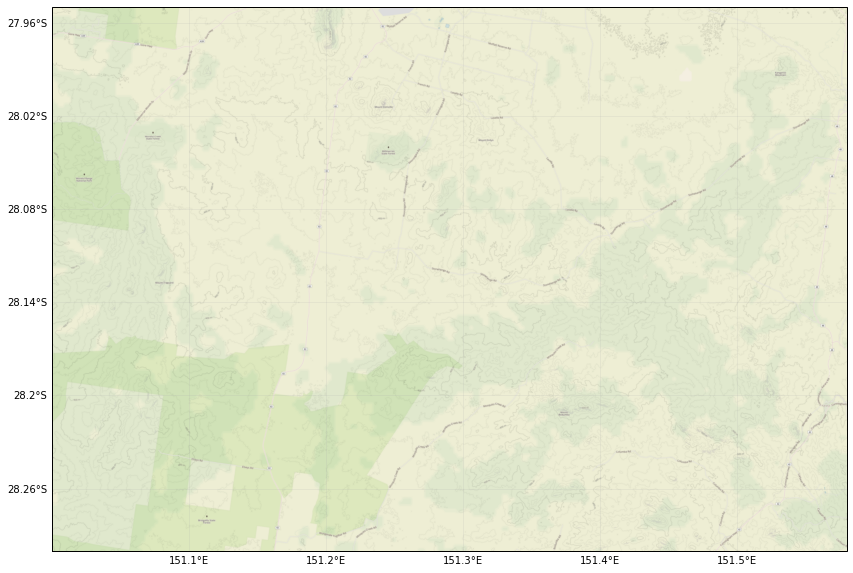

In [17]:
fig = plt.figure(figsize=(20,10))
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)
plt.show()

### Define some radar functions

In [65]:
def add_radar_contours(radar,tilt=0,field='RHOHV',levels=[.9],sigma=3,**kwargs):
    data = radar.get_field(0,'RHOHV')
    lat, lon, alt = radar.get_gate_lat_lon_alt(0)
    if sigma is not None:
        data = spyi.gaussian_filter(data, sigma=sigma)
    levels = [.9]
    ax.contour(lon, lat, data, levels, antialiased=True, transform=ccrs.PlateCarree(), **kwargs)
    
def radar_plot(path,field,tilt,apply_gatefilter=True,contour_field=None,contour_kwargs=None,**kwargs):
    myradar = pyart.aux_io.read_odim_h5(path, file_field_names=True)

    if field == 'GMM':
        model_name = 'GMM_n' + str(models[k].n_components)
        myradar.add_field(model_name,predict_labels(myradar,models[k],filt=False))

    #radar_ts = num2date(myradar.time['data'][0] + tz* 60.*60., myradar.time['units'])

    if apply_gatefilter:
        gatefilter = give_gatefilter(myradar,despecke=50,mindop=0.25,maxdop=15,snr=2,minref=15)
    else:
        gatefilter = None
    my_display = pyart.graph.RadarMapDisplay(myradar)

    im = my_display.plot_ppi_map(field,tilt,**dict(kwargs, gatefilter=gatefilter))
    
    radar_metadata = {}
    radar_metadata['timestamp'] = pd.to_datetime(num2date(myradar.time['data'][0], myradar.time['units']),utc=True)
    radar_metadata['elev'] = myradar.get_elevation(tilt)[0]
    if contour_field is not None:
        add_radar_contours(myradar,tilt,field=contour_field,**contour_kwargs)
    return radar_metadata, my_display

def apply_subplot_ticks(ax,x_custom=None,y_custom=None):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if ax in axs[-1]:
        if x_custom is not None:
            lon_formatter = LongitudeFormatter(number_format='.1f',dateline_direction_label=True)
            ax.set_xticks(x_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER

    if ax in axs[:,0]:
        if y_custom is not None:
            lat_formatter = LatitudeFormatter(number_format='.1f',dateline_direction_label=True)
            ax.set_xticks(y_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lat_formatter)
        else:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

### Define some functions for working with the isochrones, (from the Analysis-Isochrone nb)

In [19]:

def parse_isochrone_source(filename):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    return ''.join(fn_list[-1])

def parse_isochrone_time(filename,origin_tz=None):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    strdate, strtime = ''.join(fn_list[1:4]), fn_list[4]
    dt = pd.to_datetime(strdate+strtime, format='%d%m%Y%H%M')
    if origin_tz is not None:
        dt = dt.tz_localize(tz=origin_tz)
        dt = dt.tz_convert('utc')
    else:
        dt = dt.tz_localize(tz='utc')
    return dt

def parse_isochrones(fls):
    isochrone_df = pd.DataFrame({'paths':fls})

    isochrone_df['source'] = isochrone_df['paths'].apply(parse_isochrone_source)

    final_isochrone = isochrone_df[isochrone_df.source == 'final']
    isochrone_df = isochrone_df[isochrone_df.source != 'final'].copy()

    isochrone_df['datetime'] = isochrone_df['paths'].apply(parse_isochrone_time,origin_tz='Australia/Brisbane')
    isochrone_df = isochrone_df.set_index(['datetime'])
    
    start_time = isochrone_df.index.min()
    end_time = isochrone_df.index.max()
    print('Data collection duration: {}'.format(end_time-start_time))
    
    return final_isochrone, isochrone_df

def load_shapefiles_into_gdf(isochrone_df):

    isochrones_gdf = gpd.GeoDataFrame()

    for dt, row in isochrone_df.iterrows():
        iso = gpd.read_file(row['paths'])
        iso['datetime'] = dt
        iso['source'] = row['source']
        if bool(iso.crs):
            isochrones_gdf = isochrones_gdf.append(iso)
        else: 
            print('File is missing crs: {}'.format(row['paths']))
            print('Skipping...')
        
    isochrones_gdf = isochrones_gdf[['geometry','datetime','source']].reset_index()
        
    return isochrones_gdf
def add_isochrones(ax,final_edge='grey'):
    handles = []
    labels = []
    
    ax.add_geometries(final_gdf['geometry'],edgecolor=final_edge,facecolor='None',crs=ccrs.PlateCarree())
    handles.append(Line2D([0], [0], color=final_edge, lw=2))
    labels.append('Final perimeter')

    color=iter(plt.cm.rainbow_r(np.linspace(0,1,len(isochrones_gdf))))
    for i, row in isochrones_gdf.iloc[::-1].iterrows():
        c=next(color)
        ax.add_geometries([row['geometry']],facecolor=c,crs=ccrs.PlateCarree())
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=c))
        labels.append('{} ({})'.format(row['datetime'].tz_convert(target_tz).strftime(time_str_format_map),row['source']))
    
    return handles, labels

Load up the isochrone data

In [20]:
fls = glob.glob('./datasets/Perimeter Shapefiles/*.shp')
fls.sort()
final_isochrone, isochrone_df = parse_isochrones(fls)
final_gdf = gpd.read_file(final_isochrone.iloc[0].paths)
isochrones_gdf = load_shapefiles_into_gdf(isochrone_df)

Data collection duration: 1 days 12:58:00
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_5_12_2016_1348_MODIS.shp
Skipping...
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_6_12_2016_1338_VIIRS.shp
Skipping...


Should already be in the right proj, but just incase 

In [24]:
crs_proj4 = {'init': 'EPSG:4326'}#ccrs.PlateCarree().proj4_init
isochrones_gdf = isochrones_gdf.to_crs(crs_proj4)

/Users/Fuego/anaconda3/envs/radar/lib/python3.7/site-packages/pyproj/crs.py:114: DeprecationWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  DeprecationWarning,
/Users/Fuego/anaconda3/envs/radar/lib/python3.7/site-packages/pyproj/crs.py:114: DeprecationWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  DeprecationWarning,


### Define functions from the Analysis-lightning nb

In [25]:
def dt_parser(ts):
    return pd.to_datetime(ts, format='%Y %m %d %H %M %S',utc=True)

def load_lightning_data(path,header):
    lightning = pd.read_csv(path,names=header,parse_dates=[[0,1,2,3,4,5]],date_parser=dt_parser)
    lightning.rename(columns={'_'.join(header[0:6]):'datetime'},inplace=True)
    lightning = lightning.set_index(['datetime'])
    return lightning

def select_between_dt(lightning,end,start=None,delta='15T'):
    if start is None:
        start = end - pd.Timedelta('15T')
    df = lightning.loc[start.strftime('%Y-%m-%d %H:%M:%S'):end.strftime('%Y-%m-%d %H:%M:%S')].copy()
    return df
def plot_lightning(lightning,**kwargs):
    ax.scatter(lightning.lon,lightning.lat,transform=ccrs.PlateCarree(),**kwargs)
    return

Load lighting data up

In [26]:
header = ['year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond', 'lat', 'lon', 'current']
lightning = load_lightning_data('./datasets/lightning_data/Sedgerly_GPATS.txt',header=header)

## Plot a single scan in it's own fig

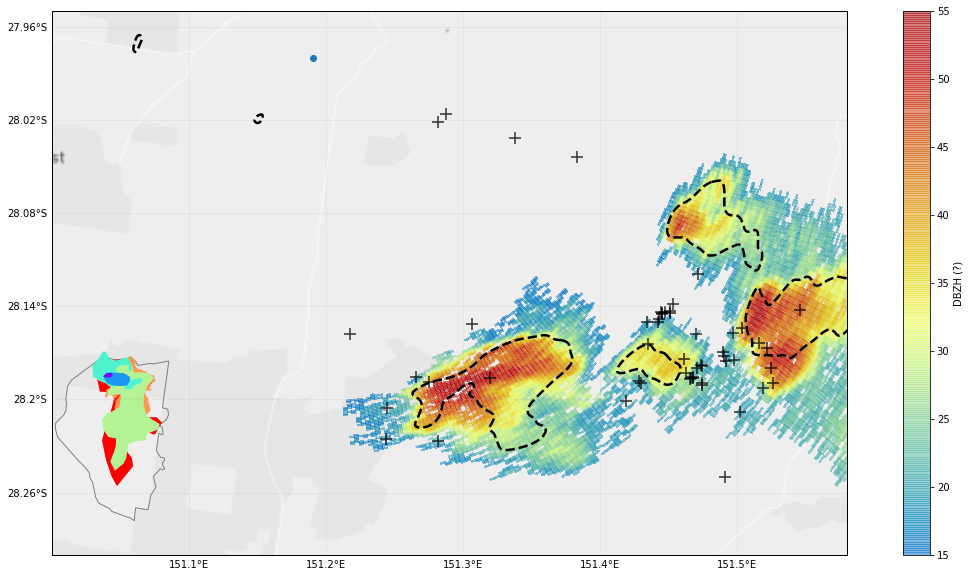

In [51]:
field = 'DBZH'
tilt=2
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format_map = '%d/%m/%Y %H:%M'

fig = plt.figure(figsize=(20,10))
tiler = MapboxTiles(mbox_key,'light')
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
ax.add_image(tiler, 10,interpolation='bilinear')
ax = formatmap(ax)



plot_args = {'vmin':15, 
            'vmax':55, 
            'projection':mercator,
            'ax':ax,
            #'cmap':'EWilson17',#pyart.graph.cm.RRate11,
            #'gatefilter':gatefilter,
            'colorbar_flag':True,
            'title_flag':False,
            'alpha':0.5}
contour_kwargs = {'linewidths':2.5, 'colors':'k', 'linestyles':'--'}
lightning_kwargs = {'color':'black','marker':'+','s':150,'alpha':0.5}


radar_metadata = radar_plot(radar_df_30M.paths.iloc[-1],field,tilt,contour_field='RHOHV',contour_kwargs=contour_kwargs,**plot_args)

handles, labels = add_isochrones(ax)
handles.extend(ax.plot(extents['uq_loc'][1],extents['uq_loc'][0],'o',transform=ccrs.PlateCarree()))
labels.append('UQ-XPOL Location')
#plt.legend(handles,labels,ncol=len(isochrones_gdf+1), bbox_to_anchor=(0, 1),loc='lower left')
#plt.legend(handles,labels,loc='upper left')
plot_lightning(select_between_dt(lightning,plot_set_timestamps_15M[-1]),**lightning_kwargs)

plt.show()

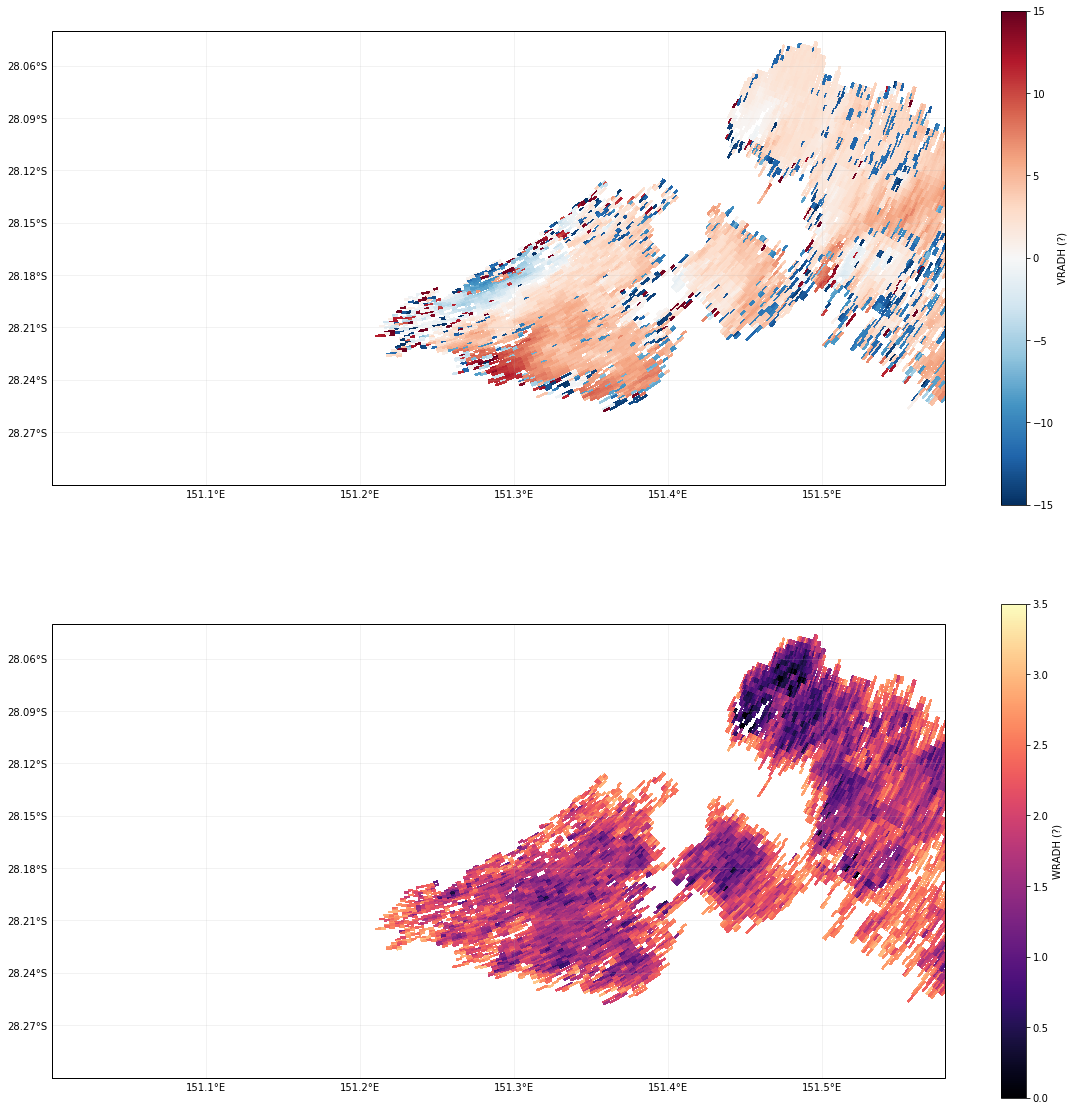

In [324]:
tilt=0

#fig = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20,20),sharex=True,subplot_kw={'projection': mercator})
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs

ax = axs[0]#plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
#ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)

field = 'VRADH'
plot_args = {'vmin':-15, 
            'vmax':15, 
            'projection':mercator,
            'ax':ax,
            'cmap':'RdBu_r',
            #'gatefilter':gatefilter,
            'colorbar_flag':True,
            'title_flag':False}
    
radar_plot(radar_df_30M.paths.iloc[-1],field,tilt,**plot_args)

ax = axs[1]#plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
#ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)

field = 'WRADH'
plot_args = {'vmin':0, 
            'vmax':3.5, 
            'projection':mercator,
            'ax':ax,
            'cmap':'magma',
            #'gatefilter':gatefilter,
            'colorbar_flag':True,
            'title_flag':False}
    
radar_plot(radar_df_30M.paths.iloc[-1],field,tilt,**plot_args)

## Plot all in plot subset in subplots

In [326]:
field='DBZH'
tilt=1
plot_args = {'vmin':15, 
            'vmax':55, 
            'projection':mercator,
            'cmap':pyart.graph.cm.RRate11,
            'colorbar_flag':False,
            'title_flag':False}

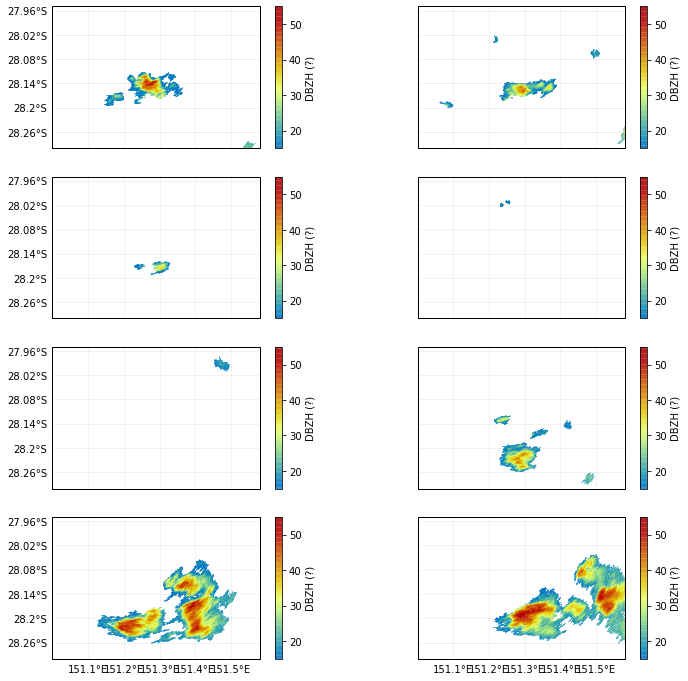

In [53]:
tiles = False
nrow = 4; ncol = 2;
assert nrow*ncol == len(radar_df_30M)
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12,12),sharex=True,subplot_kw={'projection': mercator})

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
    if tiles:
        ax.add_image(tiler, 13,interpolation='bilinear')
    plot_args['ax']=ax
    radar_plot(radar_df_30M.paths.iloc[i],field,tilt,apply_gatefilter=True,**plot_args)
    apply_subplot_ticks(ax)

plt.show()

In [33]:
radar_metadata = {}
radar_metadata['timestamp'] = 'test'

<>:65: DeprecationWarning: invalid escape sequence \m
<>:65: DeprecationWarning: invalid escape sequence \m
<>:65: DeprecationWarning: invalid escape sequence \m
<ipython-input-81-fcbbe585c4c3>:65: DeprecationWarning: invalid escape sequence \m
  im.plot_colorbar(cax=cbar_ax,label='$\mathregular{\mathit{Z_{H}}}$ (dBZ)')
/Users/Fuego/anaconda3/envs/radar/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/Fuego/anaconda3/envs/radar/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


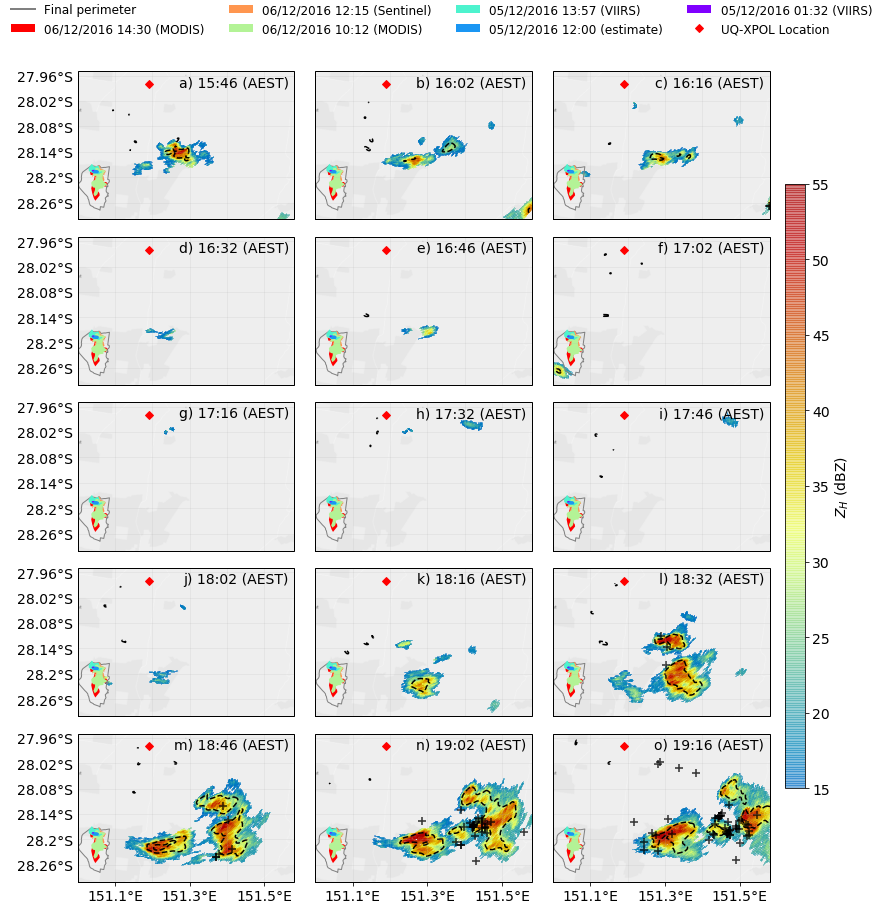

In [81]:
#%%notify

plt.rcParams.update({'font.size': 14})

dummy = False
save = True
nrow = 5; ncol = 3;
assert nrow*ncol == len(radar_df_15M)
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format = '%H:%M'
time_str_format_map = '%d/%m/%Y %H:%M'
save_str = './fig_reflectivity_subplot_15M_{}_tiles.png'


field='DBZH'
tilt=1
plot_args = {'vmin':15, 
            'vmax':55, 
            'projection':mercator,
            'ax':ax,
            #'cmap':'EWilson17',#pyart.graph.cm.RRate11,
            #'gatefilter':gatefilter,
            'colorbar_flag':False,
            'title_flag':False,
            'alpha':0.5}
contour_kwargs = {'linewidths':1.5, 'colors':'k', 'linestyles':'--'}
lightning_kwargs = {'color':'k','marker':'+','s':50,'alpha':0.5}



fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(11,12),sharex=True,subplot_kw={'projection': mercator})

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
    if not dummy:
        #ax.add_image(tiler, 13,interpolation='bilinear')
        ax.add_image(tiler, 10,interpolation='bilinear')
        plot_args['ax']=ax
        radar_metadata, im = radar_plot(radar_df_15M.paths.iloc[i],
                                        field,
                                        tilt,
                                        contour_field='RHOHV',
                                        contour_kwargs=contour_kwargs,
                                        apply_gatefilter=True,
                                        **plot_args)
        #apply_subplot_ticks(ax)
        ds_string = '{} ({})'.format(radar_metadata['timestamp'].tz_convert(target_tz).strftime(time_str_format),
                                     target_tz_name)
        ax.text(.975,.9,'{}) {}'.format(alphabet[i],ds_string),
            horizontalalignment='right',
            transform=ax.transAxes)

        plot_lightning(select_between_dt(lightning,radar_metadata['timestamp']),**lightning_kwargs)

    handles, labels = add_isochrones(ax)
    handles.extend(ax.plot(extents['uq_loc'][1],extents['uq_loc'][0],'rD',transform=ccrs.PlateCarree()))
    labels.append('UQ-XPOL Location')
    
    apply_subplot_ticks(ax,x_custom=[151.1,151.3,151.5])

fig.canvas.draw()
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.15, 0.025, 0.7])
im.plot_colorbar(cax=cbar_ax,label='$\mathregular{\mathit{Z_{H}}}$ (dBZ)')

fig.legend(handles,labels,ncol=4, bbox_to_anchor=(0, 1),loc='lower left',fontsize=12,frameon=False)

if save:
    plt.savefig(save_str.format(str(radar_metadata['elev']).replace('.','p')),dpi=300)
plt.show()